In [193]:
import numpy as np
from numpy.typing import NDArray
import pandas as pd
from typing import Optional, Tuple, Callable, Dict, Any, Sequence

from votekit.metrics import euclidean_dist
from votekit.pref_profile import RankProfile

def spatial_profile_from_types_profile_marked_data(
    number_of_ballots: int,
    candidates: list[str],
    voter_dist: Callable[..., np.ndarray] = np.random.uniform,
    voter_dist_kwargs: Optional[Dict[str, Any]] = None,
    candidate_dist: Callable[..., np.ndarray] = np.random.uniform,
    candidate_dist_kwargs: Optional[Dict[str, Any]] = None,
    distance: Callable[[np.ndarray, np.ndarray], float] = euclidean_dist,
) -> Tuple[RankProfile, dict[str, np.ndarray], np.ndarray]:
    """
    Samples a metric position for number_of_ballots voters from
    the voter distribution. Samples a metric position for each candidate
    from the input candidate distribution. With sampled
    positions, this method then creates a ranked RankProfile in which
    voter's preferences are consistent with their distances to the candidates
    in the metric space.

    Args:
        number_of_ballots (int): The number of ballots to generate.
        by_bloc (bool): Dummy variable from parent class.

    Returns:
        Tuple[RankProfile, dict[str, numpy.ndarray], numpy.ndarray]:
            A tuple containing the preference profile object,
            a dictionary with each candidate's position in the metric
            space, and a matrix where each row is a single voter's position
            in the metric space.
    """
    if voter_dist_kwargs is None:
        if voter_dist is np.random.uniform:
            voter_dist_kwargs = {"low": 0.0, "high": 1.0, "size": 2.0}
        else:
            voter_dist_kwargs = {}

    try:
        voter_dist(**voter_dist_kwargs)
    except TypeError:
        raise TypeError("Invalid kwargs for the voter distribution.")

    if candidate_dist_kwargs is None:
        if candidate_dist is np.random.uniform:
            candidate_dist_kwargs = {"low": 0.0, "high": 1.0, "size": 2.0}
        else:
            candidate_dist_kwargs = {}

    try:
        candidate_dist(**candidate_dist_kwargs)
    except TypeError:
        raise TypeError("Invalid kwargs for the candidate distribution.")

    try:
        v = voter_dist(**voter_dist_kwargs)
        c = candidate_dist(**candidate_dist_kwargs)
        distance(v.pos, c)
    except TypeError:
        raise TypeError(
            "Distance function is invalid or incompatible "
            "with voter/candidate distributions."
        )

    candidate_position_dict = {
        c: candidate_dist(**candidate_dist_kwargs) for c in candidates
    }

    voters = np.array(
        [voter_dist(**voter_dist_kwargs) for _ in range(number_of_ballots)]
    )
    voter_positions = np.array([v.pos for v in voters])

    ballot_pool = np.full((number_of_ballots, len(candidates)), frozenset("~"))

    for i in range(number_of_ballots):
        distance_tuples = [
            (c, distance(voter_positions[i], c_position))
            for c, c_position, in candidate_position_dict.items()
        ]
        candidate_ranking = np.array(
            [frozenset({t[0]}) for t in sorted(distance_tuples, key=lambda x: x[1])]
        )
        ballot_pool[i] = candidate_ranking

    n_candidates = len(candidates)
    df = pd.DataFrame(ballot_pool)
    df.index.name = "Ballot Index"
    df.columns = [f"Ranking_{i + 1}" for i in range(n_candidates)]
    df["Weight"] = 1
    df["Voter Set"] = [frozenset()] * len(df)
    return (
        RankProfile(
            candidates=candidates,
            df=df,
            max_ranking_length=n_candidates,
        ),
        candidate_position_dict,
        voters
    )

In [194]:
import votekit.ballot_generator.std_generator.spacial as spacial
import votekit.ballot_generator as bg
import numpy as np
from collections import Counter

class Person:
    def __init__(self, pos, identifier=""):
        self.pos = pos
        self.identifier = identifier

class PersonType:
    def __init__(self, generator,name="", region=""):
        self.gen = generator
        self.name = name
        self.region = region

    def identifier(self):
        return self.region + '.' + self.name
    
    def __call__(self):
        # Generate one voter
        return Person(self.gen(),self.identifier())

    def copy(self):
        return PersonType(self.gen, self.name, self.region)

    def sample(self, n):
        # Generate n voters
        return np.array([Person(self.gen(),self.identifier()) for _ in range(n)])

    def uniform_L_infinity_ball(x,y,r=1,name="",region=""):
        # Uniform Distribution
        gen = lambda: np.random.uniform(low= (x-r,y-r),high= (x+r,y+r),size= 2)
        return PersonType(gen,name,region)

    def uniform_L1_ball(x,y,r=1, name="",region=""):
        # L1 Distribution
        def gen():
            numbers = np.random.exponential(1, size = 2) # Picks two random numbers 
            normalized_numbers = numbers / numbers.sum() # Normalize so their sum adds to one
            signs = np.random.choice([-1,1], size = 2)
            points = signs * normalized_numbers # Some point on the boundary
            radius = r * (np.random.uniform(0,1) ** (1/2))
            return np.array([x,y]) + radius * points
        return PersonType(gen,name,region)

    def uniform_L2_ball(x,y,r=1,name="",region=""):
        #L2 Distribution
        def gen():
            # Pick angle and radius on a circle of radius 1
            theta = np.random.uniform(0, 2*np.pi)
            radius = r * np.sqrt(np.random.uniform(0, 1))
            return np.array([x, y]) + rad * np.array([np.cos(theta), np.sin(theta)])
        return PersonType(gen, name,region)

    def gaussian(x, y, sigma=0.5, name="",region=""):
        # Gaussian Moment, sigma is the standard deviation 
        gen = lambda: np.random.normal(loc=(x, y), scale=sigma, size=2)
        return PersonType(gen, name,region)

    def correlated_gaussian(mean, cov, name="",region=""):
        #Correlated Gaussian with full covariance.
        mean = np.array(mean, dtype=float)
        cov = np.array(cov, dtype=float)
        gen = lambda: np.random.multivariate_normal(mean= mean, cov=cov)
        return PersonType(gen, name,region)

    def combine(voter_types,name="",region=""):
        assert sum(voter_types.values()) == 1, "Need to have proportions"
        def gen():
            my_guy = np.random.choice(voter_types.keys(), p=voter_types.values())
            return my_guy.gen()
        return PersonType(gen, name, region)


class Region:
    def __init__(self,voter_types,name=""):
        self.voters=voter_types
        self.voter_types=list(voter_types.keys())
        self.amounts = list(voter_types.values())
        self.name = name
        assert len(self.voter_types) == len(self.amounts), "Dude What"
        
        tot = sum(self.amounts)
        self.proportions = [x/tot for x in self.amounts]

    def gen_one_random(self):
        my_guy = np.random.choice(self.voter_types, p=self.proportions)
        return my_guy()

    def combine(regions,name=None):
        if name == None:
            name = "__".join(region.name for region in regions)
        combined = {}
        for region in regions:
            for voter_type, amount in region.voters.items():
                new_voter_type = voter_type.copy()
                new_voter_type.region = region.name
                print(new_voter_type.region)
                combined[new_voter_type] = amount
                #combined[voter_type] = combined.get(voter_type, 0) + amount
        return Region(combined,name)
        

def voter_generator_R_sep(R=0):
    first_rand = {"low": (-1,-1),"high": (1,1), "size": 2}
    second_rand = {"low": (-1,R-1),"high": (1,R+1), "size": 2}
    choose = np.random.rand(1)
    if choose < 1/2:
        return np.random.uniform(**first_rand)
    else:
        return np.random.uniform(**second_rand)

def candidate_generator_R_sep(R=0):
    return np.random.uniform(**{"low": (-1,-1), "high": (-1,R+1), "size": 2})
    

In [195]:
from collections import defaultdict
import matplotlib.pyplot as plt

def display_by_type(voter_data, cands, shape_type, color_type):
    data_sorted = defaultdict(list)
    
    for d in voter_data:
        s = shape_type[d.identifier]
        c = color_type[d.identifier]
        data_sorted[(s,c)].append(d.pos)
    for k,v in data_sorted.items():
        plt.scatter([x[0] for x in v],[x[1] for x in v],marker=k[0],color=k[1])
    #fig, ax = plt.subplots()
    for name,pos,color in cands:
        plt.scatter(pos[0],pos[1], color=color)
        plt.annotate(name,pos)
    
    return plt.show()

def region_generator(region,num_ballots,candidate_list,candidate_dist,cand_kwargs):
    return spatial_profile_from_types_profile_marked_data(
        number_of_ballots= num_ballots,
        candidates= candidate_list,
        voter_dist=region.gen_one_random,
        candidate_dist = candidate_dist,
        candidate_dist_kwargs=cand_kwargs)

In [196]:
voter_type_K = PersonType.gaussian(0,0,name="K")
voter_type_L = PersonType.gaussian(0,4,name="L")
region_1 = Region({voter_type_K:20,voter_type_L:30},"R1")
region_2 = Region({voter_type_K:20,voter_type_L:30},"R2")
region_3=Region.combine([region_1,region_2])


cand_dist = np.random.uniform
cand_kwargs = {'low': (0,-1), 'high': (0,5), 'size': 2}
prof, cands, data = region_generator(region_3,200, ["A", "B", "C","D","E","F"], cand_dist,cand_kwargs)

R1
R1
R2
R2


In [197]:
cands

{'A': array([0.        , 1.26547978]),
 'B': array([0.        , 0.58198926]),
 'C': array([0.        , 2.95551081]),
 'D': array([ 0.        , -0.85688929]),
 'E': array([0.       , 4.7924985]),
 'F': array([0.        , 0.43508387])}

In [198]:
shape_type = {
    "R1.K": '^',
    "R1.L": '^',
    "R2.K": 'x',
    "R2.L": 'x'
}

color_type = {
    "R1.K": 'b',
    "R1.L": 'r',
    "R2.K": 'b',
    "R2.L": 'r',
    "E": 'g'
}

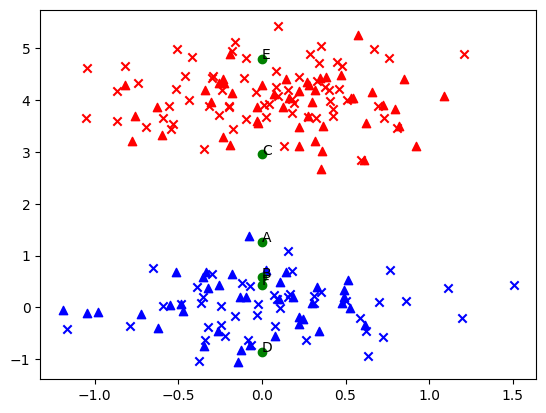

In [199]:
cands_data = []
for k,v in cands.items():
    cands_data.append((k,v,'g'))

display_by_type(data,cands_data,shape_type,color_type)

In [200]:
from votekit.elections import STV,Borda,Plurality